# Triangulate Each Cluster

In [11]:
import gc
import os
import pickle
import sys
import time
import uuid
from typing import Final, Optional

import cv2 as OpenCV
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.cluster.vq import kmeans, vq
from scipy.spatial import Delaunay
import cv2
from scipy.optimize import least_squares

import subprocess


In [12]:
class Image:
    def __init__(self, img_id, rgb_image, gray_image, mask, keypoints, descriptors, path):
        self.img_id: int = int(img_id)
        self.unique_id: uuid = uuid.uuid4()
        self.rgb_image: Image = rgb_image
        self.gray_image: Image = gray_image
        self.mask: Image = mask
        self.keypoints: list[OpenCV.KeyPoint] = keypoints
        self.descriptors: np.ndarray = descriptors
        self.path: str = path

    @property
    def length(self):
        return f"{len(self.keypoints)}" if len(self.keypoints) == len(self.descriptors) else f"{len(self.keypoints)}, {len(self.descriptors)}"
    
    def draw_sift_features(self):
        image_with_sift = OpenCV.drawKeypoints(self.rgb_image, self.keypoints, None, flags=OpenCV.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(image_with_sift)
        plt.title("Image with SIFT Features")
        plt.axis('off')
        plt.show()

    def display_rgb_image(self, title: Optional[str] = None):
        image = self.rgb_image
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axis('off')
        plt.show()

    def display_gray_image(self, title: Optional[str] = None):
        image = self.gray_image
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        plt.axes('off')
        plt.show()
        
    def display_mask_image(self, title: Optional[str] = None):
        image = self.mask
        plt.gray()
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axes('off')
        plt.show()
        
    def display_dialated_image(self, title: Optional[str] = None):
        print(self.mask.shape)
        print(self.rgb_image.shape)
        image = OpenCV.bitwise_and(self.rgb_image, self.rgb_image, mask=self.mask)
        plt.imshow(image)
        if title is not None:
            plt.title(title)
        # plt.axis('off')
        plt.show()
        
    def __repr__(self):
        return f"Image({self.img_id})"
    
    def __str__(self):
        return self.__repr__()
    
    def __eq__(self, other):
        return self.unique_id == other.unique_id
    
    def __hash__(self):
        return hash(self.img_id)
    
    def __getstate__(self):
        state = self.__dict__.copy()
        state['keypoints'] = [tuple(k.pt) + (k.size, k.angle, k.response, k.octave, k.class_id) for k in self.keypoints]
        return state
    
    def __setstate__(self, state):
        state['keypoints'] = [OpenCV.KeyPoint(x, y, size, angle, response, octave, class_id) for x, y, size, angle, response, octave, class_id in state['keypoints']]
        self.__dict__ = state

class FeatureMatches:
    def __init__(self, image_one: Image, image_two: Image, matches: list[OpenCV.DMatch]):
        self.image_one: Image = image_one
        self.image_two: Image = image_two
        self.matches: list[OpenCV.DMatch] = matches

    def draw_matches(self, output_filename: str) -> None:
        combined_image = OpenCV.hconcat([
            self.image_one.rgb_image,
            self.image_two.rgb_image
        ])
        for match in self.matches:
            x1, y1 = self.image_one.keypoints[match.queryIdx].pt
            x2, y2 = self.image_two.keypoints[match.trainIdx].pt
            # Draw a line connecting the matched keypoints
            OpenCV.line(
                combined_image, 
                (int(x1), int(y1)), 
                (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
                (0, 255, 0), 
                1
            )
        OpenCV.imwrite(output_filename, combined_image)
        
    def animate_matches(self, output_directory: str) -> None:
        for match in self.matches:
            combined_image = OpenCV.hconcat([
                self.image_one.rgb_image,
                self.image_two.rgb_image
            ])
            x1, y1 = self.image_one.keypoints[match.queryIdx].pt
            x2, y2 = self.image_two.keypoints[match.trainIdx].pt
            # Write match.queryIdx at the top left corner
            OpenCV.putText(
                combined_image,
                f"{match.queryIdx}",
                (50, 150),  # position: 10 pixels from left, 20 pixels from top
                OpenCV.FONT_HERSHEY_SIMPLEX,  # font
                5,  # font scale
                (0, 255, 0),  # font color (green)
                5,  # thickness
                OpenCV.LINE_AA  # line type
            )
            # Write match.trainIdx at the top right corner
            image_two_width = self.image_one.rgb_image.shape[1]
            OpenCV.putText(
                combined_image,
                f"{match.trainIdx}",
                (image_two_width + 50, 150),  # position: 10 pixels from right, 20 pixels from top
                OpenCV.FONT_HERSHEY_SIMPLEX,  # font
                5,  # font scale
                (0, 255, 0),  # font color (green)
                5,  # thickness
                OpenCV.LINE_AA  # line type
            )
            # Draw a line connecting the matched keypoints
            OpenCV.line(
                combined_image, 
                (int(x1), int(y1)), 
                (int(x2) + self.image_one.rgb_image.shape[1], int(y2)), 
                (0, 255, 0), 
                1
            )
            # if path does not exist, create it
            if not os.path.exists(output_directory):
                os.makedirs(output_directory)
            OpenCV.imwrite(
                f"{output_directory}/{match.queryIdx}_{match.trainIdx}.jpg",
                combined_image,
            )
        framerate = 120

        # Get a list of image files in the directory
        image_files = [f for f in os.listdir(output_directory) if f.endswith(".jpg")]
        image_files.sort(key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

        print("debugging")
        print(image_files[0])

        temp_input_file_txt_path = f"{output_directory}/input_files.txt"

        # Create a temporary file with a list of input images
        with open(temp_input_file_txt_path, "w") as f:
            for image_file in image_files:
                f.write(f"file '{image_file}'\n")

        # Run FFmpeg command to create a video
        command = f'ffmpeg -y -f concat -safe 0 -i "{temp_input_file_txt_path}" -framerate {framerate} -c:v libx264 -pix_fmt yuv420p "{output_directory.rsplit("/", 1)[0]}/output-{self.image_one.img_id}_{self.image_two.img_id}.mp4"'
        subprocess.run(command, shell=True, check=True)

        # Remove temporary file
        os.remove(temp_input_file_txt_path)
        # Remove all image files
        for image_file in image_files:
            os.remove(os.path.join(output_directory, image_file))

    def __repr__(self):
        return f"FeatureMatches({self.image_one}, {self.image_two} ---> {len(self.matches)})"

    def __getstate__(self):
        state = self.__dict__.copy()
        state['matches'] = [
            {'queryIdx': m.queryIdx, 'trainIdx': m.trainIdx, 'distance': m.distance} for m in self.matches
        ]
        return state
    
    def __setstate__(self, state):
        state['matches'] = [
            OpenCV.DMatch(match['queryIdx'], match['trainIdx'], match['distance']) for match in state['matches']
        ]
        self.__dict__ = state
    
class Images:
    def __init__(self, images: list[Image], image_set_name: str):
        self.id = uuid.uuid4()
        self.images: list[Image] = images
        self.image_set_name: str = image_set_name
        self.feature_matches: list[FeatureMatches] = []
        self.similar_images: dict[list[Image]] = {}
        self.num_clusters: int = 50

    def save_feature_matches(self):
        for match in self.feature_matches:
            match.draw_matches(f"data/{self.image_set_name}/output/feature-match/{match.image_one.img_id}_{match.image_two.img_id}.jpg")

    def __len__(self):
        return len(self.images)
    
    def display_similar_images(self, key):
        print(f"cluster {key}")
        print("-----------------------------------------------------")
        for value in self.similar_images[key]:
            print(value)
            rgb_image = OpenCV.cvtColor(OpenCV.imread(value.path), OpenCV.COLOR_BGR2RGB)
            plt.imshow(rgb_image)
            plt.title(value.path)
            plt.axis('off')
            plt.show()

    def save_similar_images(self):
        for cluster in self.similar_images.keys():
            if not os.path.exists(f"data/{self.image_set_name}/output/image-match/{cluster}"):
                os.makedirs(f"data/{self.image_set_name}/output/image-match/{cluster}")
            for value in self.similar_images[cluster]:
                OpenCV.imwrite(f"data/{self.image_set_name}/output/image-match/{cluster}/{value.img_id}.jpg", value.rgb_image)

    def __getitem__(self, key: int) -> Image:
        for image in self.images:
            if image.img_id == key:
                return image
        raise KeyError(f'Image with img_id {key} not found.')

In [13]:
def feature_matching(
        img_one_descriptors: np.ndarray, 
        img_two_descriptors: np.ndarray,
    ) -> list[OpenCV.DMatch]:
    matcher = OpenCV.BFMatcher(crossCheck=True)
    return matcher.match(img_one_descriptors, img_two_descriptors)


def apply_ransac(matches, keypoints1, keypoints2, threshold = 3.0):
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    _, mask = OpenCV.findHomography(src_pts, dst_pts, OpenCV.RANSAC, threshold)
    matches_mask = mask.ravel().tolist()
    return [m for m, keep in zip(matches, matches_mask) if keep]


def data_feature_matching(images: Images) -> None:
    import itertools
    for _, values in images.similar_images.items():
        print(images.similar_images.items())
        for image, matched_image in itertools.combinations(values, 2):
            if image.img_id != images.similar_images["0"][0].img_id:
                continue
            print(f"Matching {image.img_id} with {matched_image.img_id}")
            feature_matching_output = feature_matching(image.descriptors, matched_image.descriptors)
            ransac_output = apply_ransac(feature_matching_output, image.keypoints, matched_image.keypoints, threshold=150)
            images.feature_matches.append(FeatureMatches(image, matched_image, ransac_output))

In [14]:
import numpy as np
import cv2 as OpenCV
from typing import List, Tuple

def check_coherent_rotation(R: np.ndarray) -> bool:
    epsilon = 1e-6
    return np.abs(np.linalg.det(R) - 1.0) <= epsilon

def find_camera_matrices(K: np.ndarray, keypoints_one: np.ndarray, keypoints_two: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    E, mask = OpenCV.findEssentialMat(keypoints_one, keypoints_two, K, method=OpenCV.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K)
    # Check if the resulting rotation is coherent
    if not check_coherent_rotation(R):
        print("Resulting rotation is not coherent")
        return None, None
    print("Resulting rotation is coherent")
    return np.hstack((R, t))

def generate_point_cloud_general(images: Images, K_matrix: np.ndarray, **kwargs) -> Tuple[list[np.ndarray], np.ndarray]:
    point_cloud: list[np.ndarray] = []
    camera_matrices: list[np.ndarray] = []
    P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
    camera_matrices.append((np.eye(3), np.zeros((3, 1))))
    for feature_match in images.feature_matches:
        image_one = feature_match.image_one
        image_two = feature_match.image_two
        # Extract matched keypoints
        keypoints_one = np.array([image_one.keypoints[m.queryIdx].pt for m in feature_match.matches])
        keypoints_two = np.array([image_two.keypoints[m.trainIdx].pt for m in feature_match.matches])
        # Find Camera Matrices
        P2 = find_camera_matrices(K_matrix, keypoints_one, keypoints_two, feature_match.matches)
        if P2 is None:
            continue
        # Create projection matrices
        P2 = K_matrix @ P2
        # Triangulate points
        points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
        points_3D = (points_4D / points_4D[3])[:3]
        R = np.linalg.inv(K_matrix) @ P2[:, :3]
        t = np.linalg.inv(K_matrix) @ P2[:, 3:]
        camera_matrices.append((R, t))
        point_cloud.append(points_3D)
    # Combine point cloud and camera matrices
    point_cloud = np.hstack(point_cloud).T
    # camera_matrices = np.array(camera_matrices)
    return point_cloud, camera_matrices

In [15]:
def check_coherent_rotation(R: np.ndarray) -> bool:
    epsilon = 1e-6
    return np.abs(np.linalg.det(R) - 1.0) <= epsilon

def find_camera_matrices(K: np.ndarray, keypoints_one: np.ndarray, keypoints_two: np.ndarray, matches: List) -> Tuple[np.ndarray, np.ndarray]:
    E, mask = OpenCV.findEssentialMat(keypoints_one, keypoints_two, K, method=OpenCV.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, _ = OpenCV.recoverPose(E, keypoints_one, keypoints_two, K)
    # Check if the resulting rotation is coherent
    if not check_coherent_rotation(R):
        print("Resulting rotation is not coherent")
        return None, None
    print("Resulting rotation is coherent")
    return np.hstack((R, t))

def find_camera_matrices_from_pnp(K: np.ndarray, keypoints: np.ndarray, point_cloud: list[tuple[np.ndarray, int]]) -> Tuple[np.ndarray, np.ndarray]:
    inlier_keypoints = np.array([keypoints[p[1]] for p in point_cloud])
    inlier_points_3D = np.array([p[0] for p in point_cloud])
    _, rvec, tvec, _ = OpenCV.solvePnPRansac(inlier_points_3D, inlier_keypoints, K, None)
    R, _ = OpenCV.Rodrigues(rvec)
    return (None, None) if not check_coherent_rotation(R) else np.hstack((R, tvec))

def generate_point_cloud_ultra(images: Images, K_matrix: np.ndarray, **kwargs) -> np.ndarray:
    point_cloud = []
    reference_image = images.similar_images["0"][0]
    P1 = K_matrix @ np.hstack((np.eye(3), np.zeros((3, 1))))
    for i in range(1, len(images.images)):
        image = images.images[i]
        # Find the matching features between the reference image and the current image.
        matches = None
        for feature_match in images.feature_matches:
            if feature_match.image_one == reference_image and feature_match.image_two == image:
                matches = feature_match.matches
                break
        if matches is None:
            print(f"no matches found between reference image: {reference_image.img_id}, image: {image.img_id}")
            continue
        print(f"reference image: {reference_image.img_id}, image: {image.img_id}")
        keypoints_one = np.array([reference_image.keypoints[m.queryIdx].pt for m in matches])
        keypoints_two = np.array([image.keypoints[m.trainIdx].pt for m in matches])
        if image == images.images[1]:
            # Compute the initial camera matrix P2 using the reference image.
            P2_init = find_camera_matrices(K_matrix, keypoints_one, keypoints_two, matches)
            if P2_init is None:
                print("failed to find initial camera matrix")
                continue
            P2 = K_matrix @ P2_init
        else:
            # Perform incremental reconstruction using Perspective N-Point (PnP).
            P2_pnp = find_camera_matrices_from_pnp(K_matrix, keypoints_two, point_cloud.T, matches)
            if P2_pnp is None:
                print("failed to find camera matrix using PnP")
                continue
            P2 = K_matrix @ P2_pnp
        points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
        points_3D = (points_4D / points_4D[3])[:3]
        point_cloud.append(points_3D)

        # Triangulate points and add them to the point cloud
        points_4D = OpenCV.triangulatePoints(P1, P2, keypoints_one.T, keypoints_two.T)
        points_3D = (points_4D / points_4D[3])[:3]
        # Store the 3D points with their corresponding 2D keypoints indices
        for i in range(points_3D.shape[1]):
            point_cloud.append((points_3D[:, i], matches[i].trainIdx))
    return np.hstack(point_cloud).T

In [16]:
def dump_images_bak(images_file_path: str, images: Images) -> None:
    """ Dump images to a file """
    with open(images_file_path, "wb") as file:
        pickle.dump(images, file)

def load_images_bak(images_file_path: str) -> Images:
    """ Load images from a file """
    with open(images_file_path, "rb") as file:
        images = pickle.load(file)
    return images

In [17]:
def compute_keypoints_descriptors(images: list[Image]) -> None:
    sift = OpenCV.SIFT_create(contrastThreshold=0.01)
    for img in images.images:
        keypoints: list[OpenCV.KeyPoint]
        descriptors: np.ndarray
        dialated_image = OpenCV.bitwise_and(img.gray_image, img.gray_image, mask=img.mask)
        keypoints, descriptors = sift.detectAndCompute(dialated_image, None)
        img.keypoints = keypoints
        img.descriptors = descriptors

In [18]:
def prepare_images(create_mask = False, **kwargs) -> Images:
    image_set_name = kwargs['image_set_name']
    folder_path = f"data/{image_set_name}"
    images: Images = Images([], folder_path.split("/")[-1])
    files: list[str] = list(
        filter(
            lambda file: ".jpg" in file, os.listdir(f"{folder_path}/images")
        )
    )
    if create_mask:
        from rembg import remove
        for file in files:
            image_path = f"{folder_path}/images/{file}"
            rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
            gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
            mask = remove(rgb_image)
            mask = OpenCV.cvtColor(mask, OpenCV.COLOR_RGB2GRAY)
            mask[mask > 0] = 255
            OpenCV.imwrite(f"{folder_path}/masks/{file}", mask)
            kernel = np.ones((5, 5), np.uint8)
            dilated_mask = OpenCV.dilate(mask, kernel, iterations=20)
            images.images.append(Image(file.split(".")[0], rgb_image, gray_image, dilated_mask, [], [], image_path))
    else:
        for file in files:
            image_path = f"{folder_path}/images/{file}"
            mask_path = f"{folder_path}/masks/{file}"
            rgb_image = OpenCV.cvtColor(OpenCV.imread(image_path), OpenCV.COLOR_BGR2RGB)
            gray_image = OpenCV.cvtColor(rgb_image, OpenCV.COLOR_RGB2GRAY)
            mask = OpenCV.imread(mask_path, OpenCV.IMREAD_GRAYSCALE)
            kernel = np.ones((5, 5), np.uint8)
            dilated_mask = OpenCV.dilate(mask, kernel, iterations=20)
            images.images.append(Image(file.split(".")[0], rgb_image, gray_image, dilated_mask, [], [], image_path))
    return images

In [19]:
image_set_name = "hammer"
create_mask = False

In [20]:
images: Optional[Images] = prepare_images(create_mask=create_mask, image_set_name=image_set_name)

In [21]:
# print([image.img_id for image in images.images])

(3648, 5472)
(3648, 5472, 3)


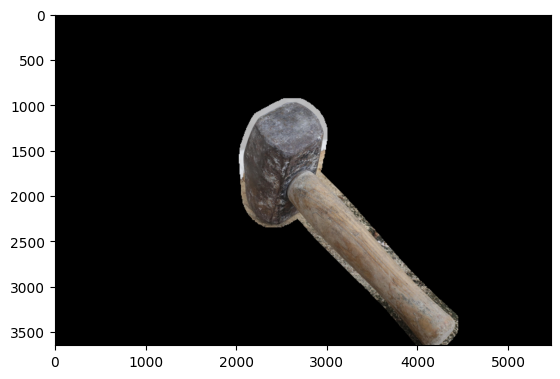

(3648, 5472)
(3648, 5472, 3)


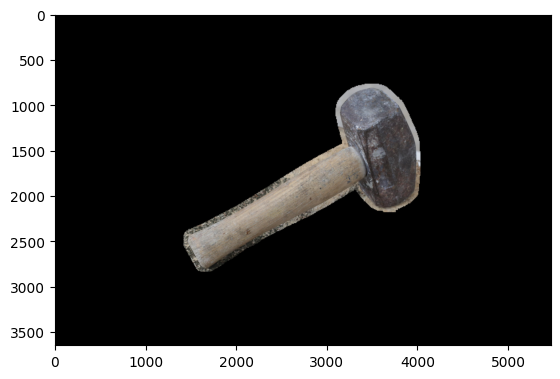

(3648, 5472)
(3648, 5472, 3)


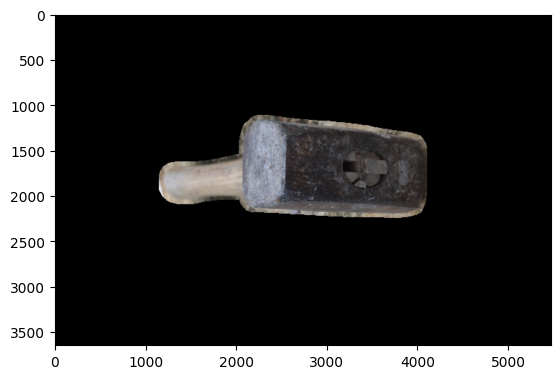

(3648, 5472)
(3648, 5472, 3)


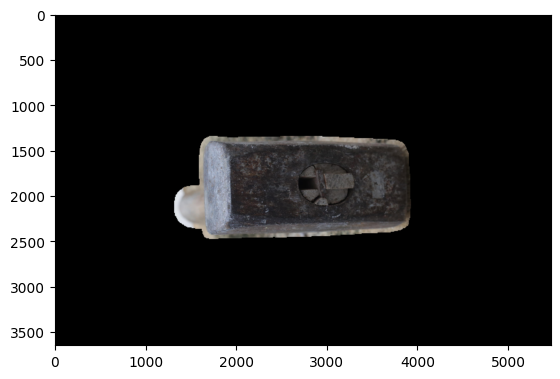

(3648, 5472)
(3648, 5472, 3)


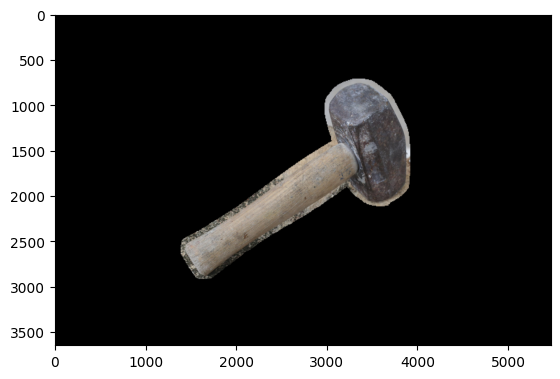

In [22]:
for image in images.images[:5]:
    image.display_dialated_image()

In [23]:
compute_keypoints_descriptors(images)

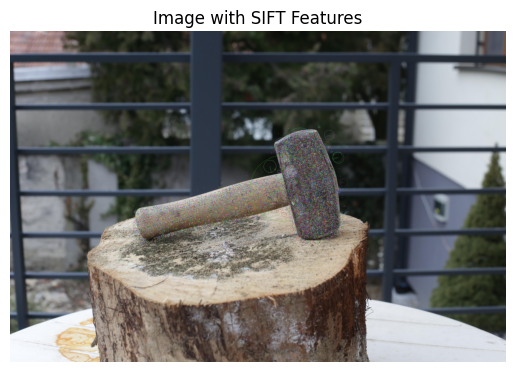

In [24]:
images[1].draw_sift_features()

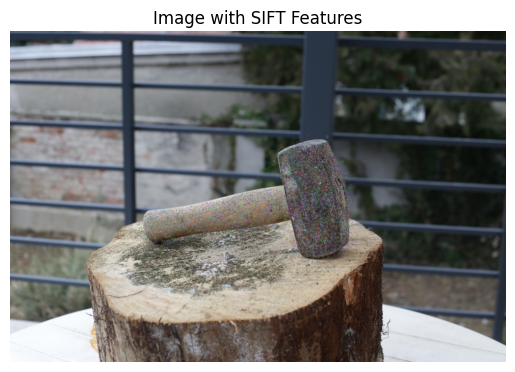

In [25]:
images[2].draw_sift_features()

In [26]:
print(images.similar_images.items())

dict_items([])


In [27]:
images.similar_images = {
    "0": [images[1], images[2]],
    # "1": [images[11], images[12], images[13], images[14], images[15], images[16], images[17], images[18], images[19], images[20], images[21], 
    #     images[22], images[23], images[24], images[25], images[26], images[27]]
}

In [28]:
print(images.similar_images.items())

dict_items([('0', [Image(1), Image(2)])])


In [29]:
data_feature_matching(images)

dict_items([('0', [Image(1), Image(2)])])
Matching 1 with 2


In [30]:
for match in images.feature_matches:
    match.draw_matches(f"data/{image_set_name}/output/triangulate/{match.image_one.img_id}_{match.image_two.img_id}.jpg")

In [31]:
# print number of matches for each image pair
for match in images.feature_matches:
    print(f"image_one: {match.image_one.img_id}, image_two: {match.image_two.img_id}, matches: {len(match.matches):,}")

image_one: 1, image_two: 2, matches: 6,838


In [32]:
# images.feature_matches[0].animate_matches(f"data/{image_set_name}/output/triangulate/1_2")

In [33]:
def compute_k_matrix(img_path: str, **kwargs) -> np.ndarray:
    import numpy as np
    focal_length: float = 7600
    principal_point_x = 2736
    principal_point_y = 1824
    scaling_factor: float = 1.0
    return np.array(
        [
            [float(focal_length), 0, principal_point_x],
            [0, float(focal_length), principal_point_y],
            [0, 0, scaling_factor],
        ]
    )
with open(f"data/{image_set_name}/bak/K_matrix.pickle", 'wb') as f:
    pickle.dump(compute_k_matrix(f"data/{image_set_name}/images"), f)

In [34]:
len(images.feature_matches[0].matches)

6838

In [35]:
import pickle
with open(f"data/{image_set_name}/bak/K_matrix.pickle", 'rb') as f:
        K_matrix = pickle.load(f)

In [36]:
import itertools
for i, j in itertools.product(range(3), range(3)):
    print(K_matrix[i][j])

7600.0
0.0
2736.0
0.0
7600.0
1824.0
0.0
0.0
1.0


# Point Cloud

In [37]:
points_cloud, camera_matrices = generate_point_cloud_general(images, K_matrix)

Resulting rotation is coherent


In [38]:
import hdbscan
hdbscan_model = hdbscan.HDBSCAN().fit(points_cloud)
labels = hdbscan_model.labels_
core_indices = np.where(labels != -1)[0]
core_points_HDBSCAN = points_cloud[core_indices, :]

In [39]:
# from sklearn.cluster import DBSCAN
# dbscan = DBSCAN(eps=0.5, min_samples=10).fit(points_cloud)
# labels = dbscan.labels_
# core_indices = np.where(labels != -1)[0]
# core_points_DBSCAN = points_cloud[core_indices, :]

In [40]:
# print(points_cloud.shape)
# print(core_points_HDBSCAN.shape)
# print(core_points_DBSCAN.shape)

In [41]:
import open3d as o3d
import numpy as np

def create_camera_frustum(P: np.ndarray, scale: float) -> o3d.geometry.TriangleMesh:
    vertices = np.array([[0.5, 0.5, 0], [0.5, -0.5, 0], [-0.5, -0.5, 0], [-0.5, 0.5, 0], [0, 0, -1]])
    vertices *= scale
    faces = np.array([[0, 1, 4], [1, 2, 4], [2, 3, 4], [3, 0, 4], [1, 0, 3]])
    R, t = P
    vertices = vertices @ R.T + t[:3].T
    mesh = o3d.geometry.TriangleMesh()
    mesh.vertices = o3d.utility.Vector3dVector(vertices)
    mesh.triangles = o3d.utility.Vector3iVector(faces)
    vertex_colors = np.ones((len(vertices), 3)) * [1, 0, 0]
    mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
    # draw camera rod
    start_point = np.array([0, 0, 0])
    end_point = np.array([0, 0, 1])*scale
    start_point = start_point @ R.T + t[:3].T
    end_point = end_point @ R.T + t[:3].T
    rod = o3d.geometry.TriangleMesh.create_cylinder(radius=0.02*scale, height=np.linalg.norm(end_point-start_point), resolution=20, split=4)
    rod.vertices = o3d.utility.Vector3dVector(np.asarray(rod.vertices) + start_point)
    vertex_colors = np.ones((len(rod.vertices), 3)) * [0, 0, 0]
    rod.vertex_colors = o3d.utility.Vector3dVector(vertex_colors)
    return mesh, rod

In [42]:
import open3d as o3d

# Create a point cloud object
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(core_points_HDBSCAN)
point_cloud.paint_uniform_color([0, 0, 1])  # Set the point cloud color to blue for better visibility

# Loop through the camera_matrices and create a red pyramid for each camera
camera_meshes = []
camera_lines = []
for camera_matrix in camera_matrices:
    camera_mesh, camera_line = create_camera_frustum(camera_matrix, scale=0.3)
    camera_meshes.append(camera_mesh)
    camera_lines.append(camera_line)

# Visualize the camera pyramids and point cloud together
# o3d.visualization.draw(camera_meshes + camera_lines + [point_cloud])

# Combine camera meshes, camera lines, and point cloud into a single mesh
combined_mesh = o3d.geometry.TriangleMesh()
for mesh in camera_meshes + camera_lines:
    combined_mesh += mesh

# Save the point cloud to a .ply file
point_cloud_file = f"data/{image_set_name}/output/triangulate/point_cloud_2_3.ply"
o3d.io.write_point_cloud(point_cloud_file, point_cloud)

# Save the combined mesh to a .ply file
mesh_file = f"data/{image_set_name}/output/triangulate/camera_proj_2_3.ply"
o3d.io.write_triangle_mesh(mesh_file, combined_mesh)

True

# Visualizing Points Cloud

In [43]:
import open3d as o3d

point_cloud_file_path = (
    f"data/{image_set_name}/output/triangulate/point_cloud_2_3.ply"
)
mesh_file_path = (
    f"data/{image_set_name}/output/triangulate/camera_proj_2_3.ply"
)

point_cloud = o3d.io.read_point_cloud(point_cloud_file_path)
mesh = o3d.io.read_triangle_mesh(mesh_file_path)

o3d.visualization.draw([point_cloud, mesh])

FEngine (64 bits) created at 0x55a6c0000 (threading is enabled)
FEngine resolved backend: OpenGL


[error] GLFW error: Cocoa: Failed to find service port for display
[error] GLFW error: Cocoa: Failed to find service port for display
[error] GLFW error: Cocoa: Failed to find service port for display
[error] GLFW error: Cocoa: Failed to find service port for display
[error] GLFW error: Cocoa: Failed to find service port for display
[error] GLFW error: Cocoa: Failed to find service port for display
[error] GLFW error: Cocoa: Failed to find service port for display


: 

: 